prepare library

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

references:
- https://towardsdatascience.com/community-detection-algorithms-9bd8951e7dae
- https://medium.com/@marcosacj/creating-and-visualizing-a-complex-network-of-instagram-hashtags-based-on-posts-about-politics-2daf24f31088
- https://github.com/marcosacj/cna-instagram/blob/master/2019-06-11-1-macj-graph-scratch.ipynb <-- coding contoh pembagian nodes & edges
- https://www.kaggle.com/datasets/arunavakrchakraborty/covid19-twitter-dataset

In [111]:
link_folder = 'write your dataset path here'

setting dataset files

In [112]:
df = pd.read_csv( link_folder+'Covid-19 Twitter Dataset (Apr-Jun 2020).csv' )
# df = pd.read_csv( link_folder+'Covid-19 Twitter Dataset (Apr-Jun 2021).csv' )

# # check unique values from attributes from df
# print( "Unique values from category column: ", sorted( df['hashtags'].unique() ), ", count: ", df['hashtags'].nunique() )

# preview data from file
# df.head()
# df.info()

lets make new columns to divide hashtags and shortening the source column value

In [113]:
# filter data based on hashtags and source value
filtered_df = df.dropna( subset=['hashtags', 'source' ] ).copy()

# create new columns
filtered_df['shorten_source'] = filtered_df['source'].copy()

# rearrange columns
filtered_df = filtered_df[ ['id', 'created_at', 'source', 'shorten_source', 'lang', 'original_text', 'favorite_count', 'retweet_count', 'original_author', 'hashtags', 'user_mentions', 'place', 'clean_tweet', 'compound', 'neg', 'neu', 'pos', 'sentiment'] ]

# preview filtered data
print( "origin data number: ", df.shape )
print( "filtered data number: ", filtered_df.shape )

origin data number:  (143903, 17)
filtered data number:  (28500, 18)


In [114]:
# filtered_df.sample( 5 )

In [115]:
def remove_delimiter_from_source_link( input_text ):
    curr_values = str( input_text ).split( ">" )
    curr_values = curr_values[ 1 ].split( "<" )
    return curr_values[0]
# end func

In [116]:
# get string value only from source value
filtered_df['shorten_source'] = [ remove_delimiter_from_source_link( val ) for val in filtered_df['source'] ]

# # check current dataframe values
# filtered_df.sample( 5 )

In [117]:
# normalize hashtags value with lowercase
filtered_df['hashtags'] = filtered_df['hashtags'].str.lower()

# # check current dataframe values
# filtered_df.sample( 5 )
# filtered_df.shape

filter posts or hashtags written in non english

In [118]:
# reference: https://www.geeksforgeeks.org/python-remove-non-english-characters-strings-from-list/

def is_english( c ):
    ascii_value = ord( c )
    return ( ascii_value >= 48 and ascii_value <= 57 ) or ( ascii_value >= 65 and ascii_value <= 90 ) or ( ascii_value >= 97 and ascii_value <= 122 ) or ascii_value==32
    # or ascii_value==44 or ascii_value==32
# end func

def remove_non_english( word ):
    english_str = ""
    for one_char in word:
        if is_english( one_char ): english_str += one_char
    # end for

    # return final english string
    return english_str
# end func 

# remove words that not writen in alphabet
def remove_words_not_written_in_eng_v1( hashtags_data ):
    # loop each posts hashtags
    for all_hashtags in hashtags_data:
        # split current post hashtags into individual hashtags
        one_posts_hash = all_hashtags.split( ", " )

        # loop tiap hashtags
        for idx, one_hash_tag in enumerate( one_posts_hash ):
            print( "idx: ", idx, ", hash: ", one_hash_tag )
            
            # hanya meloloskan hashtag yg disusun berdasarkan angka dan huruf alphabet, selain itu tidak diloloskan
            # if remove_non_english( hash )!="" and remove_non_english( hash )!=" ": all_hashtags[ idx ] = remove_non_english( hash )
            if remove_non_english( one_hash_tag )!="" and remove_non_english( one_hash_tag )!=" ":
                # print( "benar -->", remove_non_english( one_hash_tag ) )
                print( "benar -->", one_hash_tag )
            else: print( "salah -->", one_hash_tag )
            # end if else
        # end loop
    # end loop
# end func

def remove_words_not_written_in_eng_v2( hashtags_data ):
    all_data = hashtags_data.copy()

    # loop each posts hashtags
    for index_post, all_hashtags in enumerate( all_data ):
        # split current post hashtags into individual hashtags
        one_posts_hash = all_hashtags.split( ", " )

        # loop tiap hashtags
        for idx, one_hash_tag in enumerate( one_posts_hash ):
            # print( "idx: ", idx, ", hash: ", one_hash_tag )
            
            # hanya meloloskan hashtag yg disusun berdasarkan angka dan huruf alphabet, selain itu tidak diloloskan
            if remove_non_english( one_hash_tag )=="" or remove_non_english( one_hash_tag )==" ": one_posts_hash.remove( one_posts_hash[ idx ] )
            # end if else
        # end loop

        # update current available hashtags
        # all_hashtags = ", ".join( one_posts_hash )
        all_data[ index_post ] = ", ".join( one_posts_hash )
    # end loop

    # return final results
    return all_data
# end func

def remove_words_not_written_in_eng_v3( posts_hash ):
    
    # split current post hashtags into individual hashtags
    one_posts_hash = posts_hash.split( ", " )
    
    # loop tiap hashtags
    for idx, one_hash_tag in enumerate( one_posts_hash ):
        # hanya meloloskan hashtag yg disusun berdasarkan angka dan huruf alphabet, selain itu tidak diloloskan
        if remove_non_english( one_hash_tag )=="" or remove_non_english( one_hash_tag )==" ": one_posts_hash.remove( one_posts_hash[ idx ] )

        # change short mark with another mark
        if one_hash_tag.find( 'ー' ) != -1: one_hash_tag.replace( "ー", "-" )
        # end if else
    # end loop

    # return final results
    return ", ".join( one_posts_hash )
# end func

In [119]:
# filtered_df['hashtags'] = [ remove_words_not_written_in_eng_v3( val ) for val in filtered_df['hashtags'] ]
# # filtered_df['hashtags']

In [120]:
hashtags_on_posts = filtered_df['hashtags'].unique().copy()
number_current_hastags_pairs = filtered_df['hashtags'].nunique()
# print( "all hashtags on posts: ", hashtags_on_posts )
print( "all hashtags number: ", number_current_hastags_pairs )

# get list of one hashtags from posts
def get_hashtags_list( posts ):
  # initial value
  final_list_tags = []
  final_list_posts = []

  # loop tiap satu data dari hashtags, misal limit dulu ke 1000 post
  for all_hashtags in posts:
    # divide hashtags into one list
    array_hashtags = all_hashtags.lower().split( ", " )

    # save current hastags list from one post
    final_list_posts.append( array_hashtags )
    
    # loop tiap hashtags
    for hash in array_hashtags:
      # normalsasi penulisan hashtags dalam bentuk lowercase untuk meminimalkan data double
      selected_word = hash.lower()
      
      # hanya meloloskan hashtag yg disusun berdasarkan angka dan huruf alphabet, selain itu tidak diloloskan
      if selected_word not in final_list_tags and remove_non_english( selected_word )!="": final_list_tags.append( selected_word )
    # end loop
  # end loop

  # return final list
  return final_list_tags, final_list_posts
# end function

# testing function
# varitions_of_hashtags, list_of_hashtags_from_each_post = get_hashtags_list( hashtags_on_posts[0:100] ) 
varitions_of_hashtags, list_of_hashtags_from_each_post = get_hashtags_list( hashtags_on_posts ) 
print( 'banyak jenis hashtags setelah digabung: ', len( varitions_of_hashtags ) )
print( 'banyak posts: ', len( list_of_hashtags_from_each_post ) ) 

all hashtags number:  15211
banyak jenis hashtags setelah digabung:  14412
banyak posts:  15211


In [ ]:
# # save current filtered data
# filtered_df.to_csv( link_folder+'data_filtered'+'.csv', index=False )

Start create csv nodes-edges files

In [121]:
# limit the processed data
max_data = 1000

# set new file name
new_file_name = 'edges_list_basic_'

In [122]:
# select data where post using more than one hashtags
selected_hash = [ one_post.split( ", " ) for one_post in filtered_df['hashtags'][:max_data] if len( one_post.split( ", " ) ) > 1 ]
print( "before hash spelling in eng checked: ", len( selected_hash ) )

before hash spelling in eng checked:  2042


In [123]:
# initialize edge pair results
edge_pair_list_all = []
edge_pair_list_keys = []

# create tuple only when a post has more than one hashtags
for hashtags_from_one_post in selected_hash:
    for i in range( len( hashtags_from_one_post ) ):
        for j in range( i+1, len( hashtags_from_one_post ) ):
            one_pair = ( hashtags_from_one_post[ i ], hashtags_from_one_post[ j ] )
            edge_pair_list_all.append( one_pair )
            if one_pair not in edge_pair_list_keys:
                edge_pair_list_keys.append( one_pair )
            # end if
        # end loop of j
    # end loop of i
# end loop of selected hash

# check current dataframe values
# print( "before: ", selected_hash )
# print( "after: ", edge_pair_list_all )
# print( "after: ", edge_pair_list_keys )
print( "len edge pair all: ", len( edge_pair_list_all ) )
print( "len edge pair keys: ", len( edge_pair_list_keys ) )

len edge pair all:  7007
len edge pair keys:  5935


In [124]:
# try to create graph from created edge list all
import networkx as nx
G = nx.from_edgelist( edge_pair_list_all )

# check current dataframe values
# print( "current available nodes: ", list( G.nodes ) )
# print( "current available edges: ", list( G.edges() ) )
print( "current available nodes: ", len( G.nodes ) )
print( "current available edges: ", len( G.edges() ) )


current available nodes:  2662
current available edges:  5701


In [125]:
# set all edge pair into new dataframe
df_edges_list = pd.DataFrame( edge_pair_list_all, columns=['source', 'target'] )

# check current dataframe values
# df_edges_list.sample( 5 )
df_edges_list

,source,target
0,oic,islamophobic
1,oic,india
2,oic,covid
3,islamophobic,india
4,islamophobic,covid
...,...,...
7002,jypentertainment,twice
7003,ecommerce,covidー19
7004,ecommerce,staysafenigeria
7005,covidー19,staysafenigeria


In [126]:
# import to new file csv
df_edges_list.to_csv( link_folder+new_file_name+str( max_data )+'.csv', index=False )

In [127]:
# set new column for each hashtags pair
df_edges_list['tuple'] = pd.Series( zip( df_edges_list['source'], df_edges_list['target'] ) )

# # check current dataframe values
# df_edges_list.sample( 5 )

In [128]:
# group each tuple to be used as edge weight
grouped_edges_list = df_edges_list.groupby( 'tuple' ).count()

# check current dataframe values
grouped_edges_list.head( 5 )

,source,target
tuple,,
"(199bn, crpf)",1,1
"(1u, disinfectants)",1,1
"(1u, notmeus)",1,1
"(2019ncov, apfightscorona)",1,1
"(2019ncov, who)",1,1


In [129]:
# drop one column either source or target since both of attribute has same values
grouped_edges_list.drop( columns='target', inplace=True, errors='ignore' )

# rename column
grouped_edges_list.columns = ['weight']
grouped_edges_list.reset_index( inplace=True )

# check current dataframe values
grouped_edges_list.sample( 5 )
# grouped_edges_list.shape

,tuple,weight
3544,"(lockdown, stayhomesavelifes)",1
3653,"(luxury, marketing)",1
3058,"(injectdisinfectant, poison)",1
3290,"(karakexpressnews, coronainpakistan)",1
3469,"(lions, sheep)",1


In [130]:
# add new column source and target
grouped_edges_list[ 'source' ] = grouped_edges_list['tuple'].str[0]
grouped_edges_list[ 'target' ] = grouped_edges_list['tuple'].str[1]

# drop tuple column
grouped_edges_list = grouped_edges_list.drop( columns='tuple' )

# rearrange columns order
grouped_edges_list = grouped_edges_list[ ['source', 'target', 'weight'] ]

# check current dataframe values
grouped_edges_list.sample( 5 )

,source,target,weight
108,airpollution,pollution,1
2865,healthylifestyle,healthfirst,1
1,1u,disinfectants,1
1578,covid_19,chinavirus,1
27,7moredays,coronavirus,1


In [131]:
# import to new file csv
grouped_edges_list.to_csv( link_folder+new_file_name+'with_weight_'+str( max_data )+'.csv', index=False )

In [132]:
# # check values
# check_edges_with_weight_more_than_one = grouped_edges_list[ grouped_edges_list['weight'] > 2 ]
# print( "current shape", check_edges_with_weight_more_than_one.shape )
# check_edges_with_weight_more_than_one.sample( 5 )

new graph from created edges group

In [133]:
# open saved edges data file
df_edge_grouped = pd.read_csv( link_folder+new_file_name+'with_weight_'+str( max_data )+'.csv' )
new_graph = nx.from_pandas_edgelist( df_edge_grouped, edge_attr=True )

# check nodes and edges number from saved file
print( "nodes: ", len( new_graph.nodes ) )
print( "edges: ", len( new_graph.edges ) )

nodes:  2662
edges:  5701


In [134]:
# check nodes on current network
list( new_graph.nodes )[:10]

['199bn',
 'crpf',
 '1u',
 'disinfectants',
 'notmeus',
 '2019ncov',
 'apfightscorona',
 'who',
 '25_april',
 'عهد_الانهيار']

In [135]:
# check edges on current network
list( new_graph.edges( data=True ) )[:10]

[('199bn', 'crpf', {'weight': 1}),
 ('1u', 'disinfectants', {'weight': 1}),
 ('1u', 'notmeus', {'weight': 1}),
 ('1u', 'coronavirus', {'weight': 1}),
 ('1u', 'covid_19', {'weight': 1}),
 ('1u', 'disinfectant', {'weight': 1}),
 ('1u', 'resist', {'weight': 1}),
 ('1u', 'stayhome', {'weight': 1}),
 ('1u', 'ultraviolet', {'weight': 1}),
 ('disinfectants', 'americans', {'weight': 1})]

C:\Users\medin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\medin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\medin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2370 (\N{DEVANAGARI VOWEL SIGN UU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\medin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2331 (\N{DEVANAGARI LETTER CHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\medin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) 

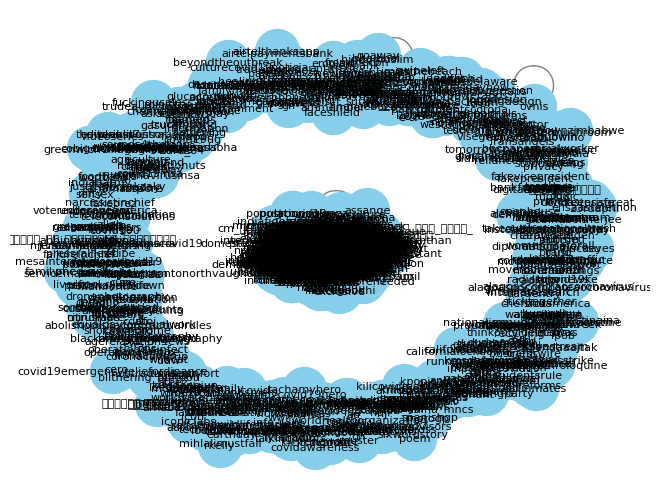

In [136]:
# Visualization
pos = nx.spring_layout( new_graph )  # or use another layout algorithm
nx.draw( new_graph, pos, with_labels=True, font_size=8, node_size=1000, font_color='black', node_color='skyblue', edge_color='gray')
plt.show()